In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 訓練データ用CSVの読み込み
train_data = pd.read_csv("nagaoka_gc/train/train_data.csv")
train_data.head()

,File name,GC
0,08DE663C,0
1,08EE752D,1
2,08DE663D,0
3,08EE751D,1
4,08DE664B,0


In [3]:
# テストデータ用CSVの読み込み
test_data = pd.read_csv("nagaoka_gc/test/test_data.csv")
test_data.head()

,File name,GC
0,08DE762D,0
1,08EE780C,1
2,08EE050C,0
3,08EE972C,1
4,08DE863C,0


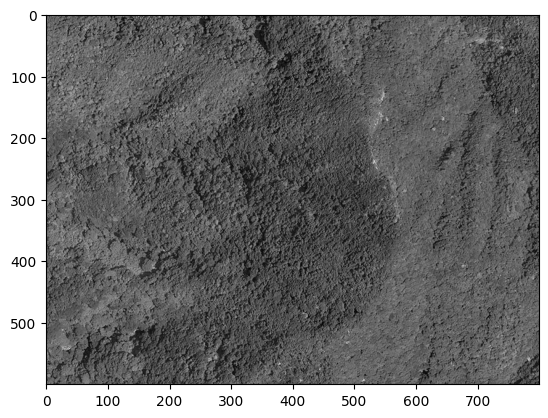

In [4]:
# ゴルフ場が写っていない写真をグレースケール化して表示
sample_img1 = Image.open("nagaoka_gc/train/08DE663C.jpg").convert("L")
plt.imshow(sample_img1, cmap="gray")

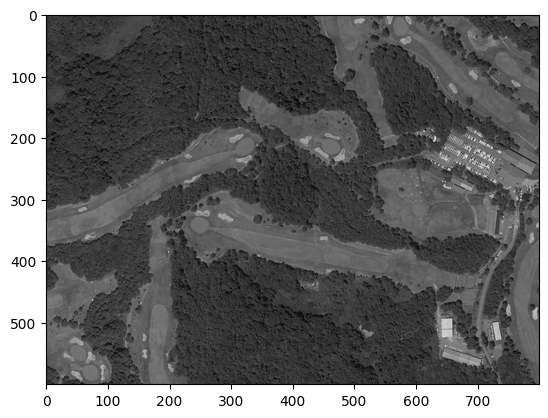

In [5]:
# ゴルフ場が写っている写真をグレースケール化して表示
sample_img2 = Image.open("nagaoka_gc/train/08EE752D.jpg").convert("L")
plt.imshow(sample_img2, cmap="gray")

In [6]:
# グレースケール化した写真をndarrayに変換してサイズを確認
sample_img1_array = np.array(sample_img1)
sample_img1_array.shape

(600, 800)

In [7]:
# 訓練用の航空写真の読み込み

# ndarrayのデータを保管する領域の確保
train_len = len(train_data)
# 左右、上下、180度回転させたものを用意するため、4倍の容量を確保する
X_train = np.empty((train_len * 4, 480000), dtype=np.uint8)                #X_trainは、train_lenの4倍の行数、それぞれの行に、画素数(600×800) の画像データが入る2次元配列とする。
y_train = np.empty(train_len * 4, dtype=np.uint8)                          #y_trainは、train_lenの4倍の行数、それぞれの行に、ゴルフ場がある:1・なし:0の1つの数字が入る1次元配列とする。

# 画像ひとつひとつについて繰り返し処理
for i in range(len(train_data)):

    # 基の画像をndarrayとして読み込んで訓練データに追加
    name = train_data.loc[i, "File name"]                                  #train_dataのi行目のFile nameを取得し、nameに格納する。
    train_img = Image.open(f"nagaoka_gc/train/{name}.jpg").convert("L")    #nameに格納されているFile nameの画像データを、convert("L")で白黒に変換する。
    train_img = np.array(train_img)                                        #numpyのndarrayに変換する。
    train_img_f = train_img.flatten()                                      #train_imgは2次元配列になっているので、flatten()を施して、1次元配列に直す。
    X_train[i] = train_img_f                                               #作成したデータを計測データのi行目に格納する。
    y_train[i] = train_data.loc[i, "GC"]                                   #train_dataのi行目のGC(ゴルフ場あり:1、なし:0)を教師データのi行目に格納する。   

    # 左右反転させたものを訓練データに追加
    train_img_lr = np.fliplr(train_img)                                    #fliplrを施して、左(left)右(right)反転する。
    train_img_lr_f = train_img_lr.flatten()
    X_train[i + train_len] = train_img_lr_f
    y_train[i + train_len] = train_data.loc[i, "GC"]

    # 上下反転させたものを訓練データに追加
    train_img_ud = np.flipud(train_img)                                  #flipudを施して、上(up)下(down)反転する。
    train_img_ud_f = train_img_ud.flatten()
    X_train[i + train_len * 2] = train_img_ud_f
    y_train[i + train_len * 2] = train_data.loc[i, "GC"]

    # 180度回転させたものを訓練データに追加
    train_img_180 = np.rot90(train_img, 2)                               #rot90を施して、180度(反時計回りに90度×"2"、"2"はrot90の2番目の引数)回転する。
    train_img_180_f = train_img_180.flatten()
    X_train[i + train_len * 3] = train_img_180_f
    y_train[i + train_len * 3] = train_data.loc[i, "GC"]

In [10]:
# テスト用の航空写真の読み込み

# ndarrayのデータを保管する領域の確保
test_len = len(test_data)
X_test = np.empty((test_len, 480000), dtype=np.uint8)
y_test = np.empty(test_len, dtype=np.uint8)

# 画像ひとつひとつについて繰り返し処理
for i in range(test_len):

    # ndarrayとして読み込んでテストデータに追加
    name = test_data.loc[i, "File name"]
    test_img = Image.open(f"nagaoka_gc/test/{name}.jpg").convert("L")
    test_img = np.array(test_img)
    test_img_f = test_img.flatten()
    X_test[i] = test_img_f
    y_test[i] = test_data.loc[i, "GC"]

In [11]:
# 分類器の作成
classifier = SVC(kernel="linear")
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [12]:
# 分類の実施と結果表示
y_pred = classifier.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 1], dtype=uint8)

In [13]:
# 正解の表示
y_test

array([0, 1, 0, 1, 0, 1], dtype=uint8)

In [14]:
# 混同行列で正答数の確認
print(metrics.confusion_matrix(y_test, y_pred))

[[3 0]
 [0 3]]
